**음악의 표현 방법**

In [5]:
import IPython.display as ipd
from IPython.display import Image
from IPython.display import Audio
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
from collections import OrderedDict

from util import plot_signal, plot_matrix

# 3. 오디오 표현

- 음악가들은 악보에 있는 것을 연주할 때 소리를 기압 진동으로 공기로 보낸다. 간단히 말해 소리는 공기 진동이다.
소리는 종파(longitundinal waves)를 통해 진동한다.

- 오디오는 인간이 들을 수 있는 소리의 생산, 전송 또는 수신을 의미한다. 
- 오디오 신호는 진동에 의해 발생하는 기압의 변동을 시간의 함수로 나타내는 소리의 표현이다. 
- 악보나 심볼릭 표현과는 달리, 오디오 표현은 음악의 음향적 실현을 재현하는 데 필요한 모든 것을 인코딩한다. 그러나 온셋, 지속 시간(duration) 및 피치와 같은 참고 매개 변수는 명시적으로 인코딩되지 않는다. 오디오 표현에서 기호 표현으로 변환하는 것을 어려운 작업이다.

### 음파 Waveforms

- 소리는 가수의 성대, 바이올린의 현과 소리판 등의 진동하는 물체에 의해 발생한다. 이러한 진동은 공기 분자의 변위와 진동을 유발하여 지역적인 압축(compression)과 희박화(rarefaction)를 초래한다.
- 교류 압력(alternating pressure)은 공기를 통해 파동으로 청취자 또는 마이크로 전달된다. 그것은 사람에 의해 소리로 인식되거나 마이크에 의해 전기 신호로 변환될 수 있다. 
- 그래픽적으로 특정 위치의 기압 변화는 **pressure-time plot**으로 나타낼 수 있으며, 이는 **waveform**이라고도 한다. 
- waveform은 평균 공기압으로부터 공기압의 편차를 나타낸다.

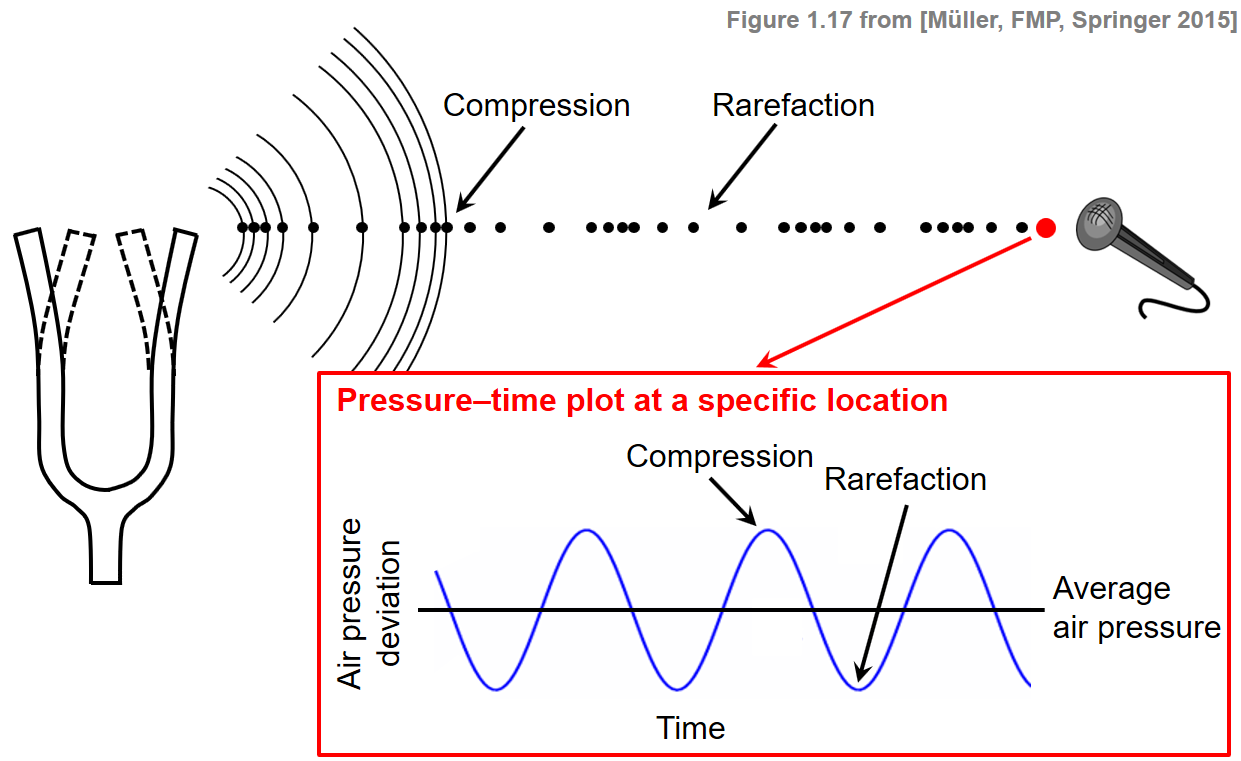

In [6]:
Image("../img/2.music_representation/FMP_C1_F17.png", width=500, height=500)

In [7]:
import librosa
import librosa.display

In [8]:
x, sr = librosa.load('../audio/c_strum.wav')
print("샘플링 레이트: ",sr)
ipd.Audio(x, rate=sr)

샘플링 레이트:  22050


- 위 오디오를 waveform으로 보이면 다음과 같다.

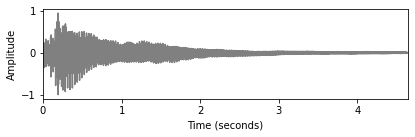

In [9]:
plot_signal(x,sr,ylabel='Amplitude')
plt.show()

- 공기압이 높은 지점과 낮은 지점이 번갈아가며 규칙적으로 반복되는 경우 결과 파형을 주기적(periodic)이라고 한다. 
- 이 경우 파동의 주기는 주기를 완료하는 데 필요한 시간으로 정의된다. 
- 헤르츠(Hz) 단위로 측정된 주파수는 주기의 역수이다. 
- 다음 그림은 가장 단순한 유형의 주기 파형인 사인파(sinusoid)를 보여준다.
    - 이 예에서 파형의 주기는 25초이므로 주파수는 4Hz이다. 
    - 주기적 파형의 가장 단순한 유형은 사인파이며, 주파수(frequency), 진폭(amplitude)(평균에서 사인파의 피크 편차), 위상(phase)(주기에서 사인파가 0인 위치를 결정함)에 의해 완전히 지정된다.

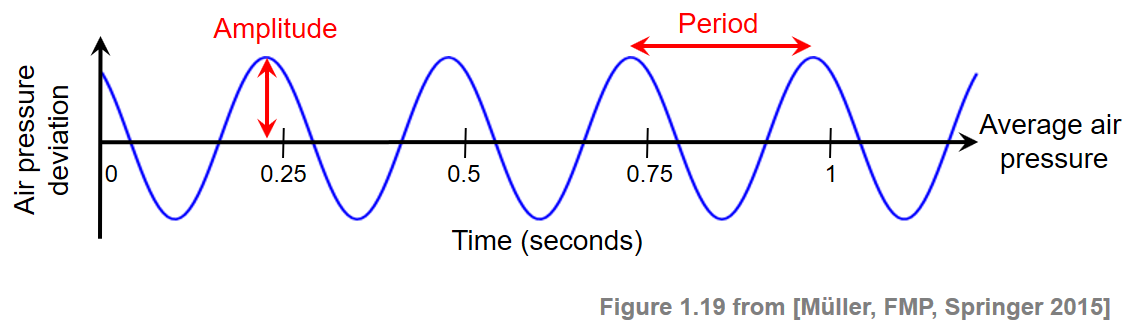

In [10]:
Image("../img/2.music_representation/FMP_C1_F19.png", width=600, height=600)

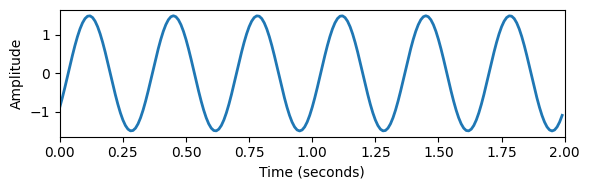

In [11]:
Fs = 100
duration = 2
amplitude = 1.5
phase = 0.1
frequency = 3

num_samples = int(Fs * duration)
t = np.arange(num_samples) / Fs
x = amplitude * np.sin(2 * np.pi * (frequency * t - phase))

plt.figure(figsize=(6, 2))
plt.plot(t, x,  linewidth=2.0)
plt.xlim([0, duration])
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.tight_layout()

- 디지털 컴퓨터는 이 데이터를 이산적인(discrete) 시간으로 밖에 포착(capture)하지 못한다.
- 컴퓨터가 잡는 오디오 데이터의 rate를 샘플링 주파수, 샘플링 레이트(sampling frequency, sampling rate, 이하 fs)라고 한다.
- 예를 들어 FS가 44100 Hz이면 CD 레코딩의 샘플링 레이트이다. https://en.wikipedia.org/wiki/Sampling_(signal_processing)#Audio_sampling

---
### 주파수와 피치 Frequency and Pitch

- 주파수 설명 참고 (한글): http://www.ktword.co.kr/test/view/view.php?m_temp1=4148

**들을 수 있는 주파수 범위**

- 사인파의 주파수가 높을수록 더 높은 소리를 낸다. 
- 인간의 가청 주파수 범위는 약 20 Hz와 20000 Hz(20 kHz) 사이이다. 다른 종들은 다른 청력 범위를 가지고 있다. 예를 들어, 개의 청력 범위의 상단은 약 45 kHz이고 고양이의 청력은 64 kHz인 반면, 박쥐는 심지어 100 kHz 이상의 주파수를 감지할 수 있다. 사람의 청각 능력을 뛰어넘는 초음파를 내는 개 호루라기를 이용해 주변 사람들을 방해하지 않고 동물을 훈련시키고 명령할 수 있는 이유다.

- 다음 실험에서 주파수가 초당 2배(1옥타브) 증가하는 차프(chirp) 신호를 생성한다.

In [12]:
import libfmp.c1

# 20Hz부터 시작하여 주파수는 총 10초 동안 20480Hz까지 상승한다.
Fs = 44100
dur = 1
freq_start = 20 * 2**np.arange(10)
for f in freq_start:
    if f==freq_start[0]:
        chirp, t = libfmp.c1.generate_chirp_exp_octave(freq_start=f, dur=dur, Fs=Fs, amp=.25)
    else:
        chirp_oct, t = libfmp.c1.generate_chirp_exp_octave(freq_start=f, dur=dur, Fs=Fs, amp=.25)
        chirp = np.concatenate((chirp, chirp_oct))

ipd.display(ipd.Audio(chirp, rate=Fs))

In [13]:
# 640Hz부터 시작하여 주파수는 총 10초 동안 20Hz까지 하락한다.

Fs = 8000
dur = 2
freq_start = 20 * 2**np.arange(5)
for f in freq_start:
    if f==freq_start[0]:
        chirp, t = libfmp.c1.generate_chirp_exp_octave(freq_start=f, dur=dur, Fs=Fs, amp=1)
    else:
        chirp_oct, t = libfmp.c1.generate_chirp_exp_octave(freq_start=f, dur=dur, Fs=Fs, amp=1)
        chirp = np.concatenate((chirp,chirp_oct))    
        
chirp = chirp[::-1]    
ipd.display(ipd.Audio(chirp, rate=Fs))

**피치와 중심 주파수**

- 사인파는 음표의 음향적 실현의 원형으로 간주될 수 있다. 때때로 사인파에서 나오는 소리를 조화로운 소리(harmonic sound) 또는 순수한 음색(pure tone)이라고 한다. 

- 주파수의 개념은 소리의 음높이를 결정하는 것과 밀접한 관련이 있다. 일반적으로 피치는 소리의 주관적인 속성이다. 

- 복잡한 혼합음의 경우, 주파수와의 관계가 특히 모호할 수 있다. 그러나 순수한 음색의 경우 주파수와 음높이의 관계가 명확하다. 예를 들어, 440 Hz의 주파수를 갖는 사인파는 피치 A4에 해당한다. 이 특정한 피치는 콘서트 피치(concert pitch)로 알려져 있으며, 이는 연주를 위해 악기가 튜닝되는 기준 피치로 사용된다. 

- 주파수의 약간의 변화가 반드시 지각된 변화로 이어지는 것은 아니기 때문에, 일반적으로 주파수의 전체 범위를 단일 피치와 연관시킨다.


- 두 주파수가 2의 거듭제곱에 의해 차이가 나는 경우, 이는 옥타브의 개념과 연관된다.
    - 예를 들어, 피치 A3(220 Hz)와 피치 A4(440 Hz) 사이의 인식 거리는 피치 A4와 피치 A5(880 Hz) 사이의 인식 거리와 동일하다. 
    - 즉, 피치에 대한 인간의 인식은 본질적으로 로그이다. 이 지각 특성은 이미 로그 주파수 축을 기준으로 옥타브를 12개의 반음으로 세분화하는 equal-tempered scale를 정의하는 데 사용되었다.

- 더 공식적으로, MIDI 노트 번호를 사용하여, 우리는 다음과 같이 정의된 **중심 주파수**(center frequency) $F_{pitch}(p)$(Hz 단위로 측정)를 각 피치 $p∈[0:127]$
에 연결할 수 있다.
    - $F_{pitch}(p)=2^{(p−69)/12} \cdot 440$
        - MIDI 노트 번호 $p=69$는 기준으로 사용되며 피치 A4(440Hz)에 해당된다. 피치 넘버를 12(옥타브) 증가시키면 2배 증가한다. $F_{pitch} ( p + 12) = 2 \cdot F_{pitch} ( p)$

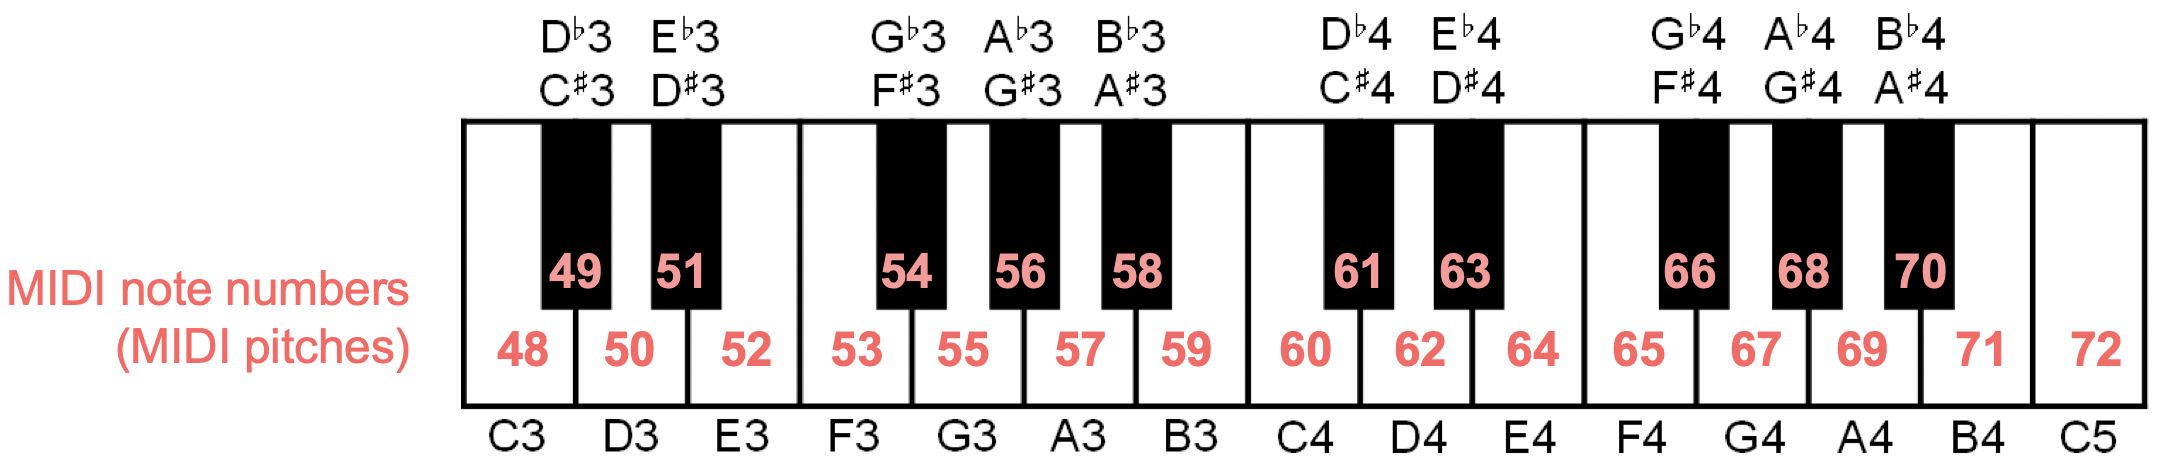

In [14]:
Image("../img/2.music_representation/FMP_C1_MIDI-NoteNumbers.png", width=500, height=500)

In [15]:
def f_pitch(p):
    """Compute center frequency for (single or array of) MIDI note numbers

    Args:
        p (float or np.ndarray): MIDI note numbers

    Returns:
        freq_center (float or np.ndarray): Center frequency
    """
    freq_center = 2 ** ((p - 69) / 12) * 440
    return freq_center

chroma = ['A ', 'A#', 'B ', 'C ', 'C#', 'D ', 'D#', 'E ', 'F ', 'F#', 'G ', 'G#']

for p in range(21, 109):
    print('p = %3d (%2s%1d), freq = %7.2f ' % (p, chroma[(p-69) % 12], (p//12-1), f_pitch(p)))

p =  21 (A 0), freq =   27.50 
p =  22 (A#0), freq =   29.14 
p =  23 (B 0), freq =   30.87 
p =  24 (C 1), freq =   32.70 
p =  25 (C#1), freq =   34.65 
p =  26 (D 1), freq =   36.71 
p =  27 (D#1), freq =   38.89 
p =  28 (E 1), freq =   41.20 
p =  29 (F 1), freq =   43.65 
p =  30 (F#1), freq =   46.25 
p =  31 (G 1), freq =   49.00 
p =  32 (G#1), freq =   51.91 
p =  33 (A 1), freq =   55.00 
p =  34 (A#1), freq =   58.27 
p =  35 (B 1), freq =   61.74 
p =  36 (C 2), freq =   65.41 
p =  37 (C#2), freq =   69.30 
p =  38 (D 2), freq =   73.42 
p =  39 (D#2), freq =   77.78 
p =  40 (E 2), freq =   82.41 
p =  41 (F 2), freq =   87.31 
p =  42 (F#2), freq =   92.50 
p =  43 (G 2), freq =   98.00 
p =  44 (G#2), freq =  103.83 
p =  45 (A 2), freq =  110.00 
p =  46 (A#2), freq =  116.54 
p =  47 (B 2), freq =  123.47 
p =  48 (C 3), freq =  130.81 
p =  49 (C#3), freq =  138.59 
p =  50 (D 3), freq =  146.83 
p =  51 (D#3), freq =  155.56 
p =  52 (E 3), freq =  164.81 
p =  53 

- 이 공식으로부터, 두 개의 연속된 피치 p+1과 p의 주파수 비율은 일정하다.
    - $F_\mathrm{pitch}(p+1)/F_\mathrm{pitch}(p) = 2^{1/12} \approx  1.059463$

- 반음의 개념을 일반화하여 **센트**(**cent**)는 음악 간격에 사용되는 로그 단위를 나타낸다. 정의에 따라 옥타브는 $1200$ 센트로 나뉘며, 각 반음은 $100$센트에 해당한다. 두 주파수(예: $\omega_1$ 및 $\omega_2$) 사이의 센트 차이는 다음과 같다.
    - $\log_2\left(\frac{\omega_1}{\omega_2}\right)\cdot 1200.$

- 1센트의 간격은 너무 작아서 연속된 음 사이를 들을 수 없다. 지각할 수 있는 것의 문턱은 사람마다 다르고 음색과 음악적 맥락과 같은 다른 측면에 따라 달라진다. 경험에 비추어 볼 때, 일반적인 성인들은 음높이의 차이가 작다는 것을 인식할 수 있다.
- 경험적으로 일반 성인은 25달러센트의 작은 음높이 차이를 매우 안정적으로 인식할 수 있으며, 10달러센트의 차이는 훈련된 청취자만이 인식할 수 있다.
- 그림에서와 같이, 우리는 기준으로 사용되는 $440~\mathrm{Hz}$의 정현파와 다양한 차이를 가진 추가 정현파를 생성한다.

In [16]:
def difference_cents(freq_1, freq_2):
    """Difference between two frequency values specified in cents

    Args:
        freq_1 (float): First frequency
        freq_2 (float): Second frequency

    Returns:
        delta (float): Difference in cents
    """
    delta = np.log2(freq_1 / freq_2) * 1200
    return delta
 
def generate_sinusoid(dur=1, Fs=1000, amp=1, freq=1, phase=0):
    """Generation of sinusoid

    Args:
        dur (float): Duration (in seconds) (Default value = 5)
        Fs (scalar): Sampling rate (Default value = 1000)
        amp (float): Amplitude of sinusoid (Default value = 1)
        freq (float): Frequency of sinusoid (Default value = 1)
        phase (float): Phase of sinusoid (Default value = 0)

    Returns:
        x (np.ndarray): Signal
        t (np.ndarray): Time axis (in seconds)

    """
    num_samples = int(Fs * dur)
    t = np.arange(num_samples) / Fs
    x = amp * np.sin(2*np.pi*(freq*t-phase))
    return x, t

dur = 1
Fs = 4000
pitch = 69
ref = f_pitch(pitch)
freq_list = ref + np.array([0,2,5,10,ref])
for freq in freq_list:
    x, t = generate_sinusoid(dur=dur, Fs=Fs, freq=freq)
    print('freq = %0.1f Hz (MIDI note number 69 + %0.2f cents)' % (freq, difference_cents(freq,ref)))
    ipd.display(ipd.Audio(data=x, rate=Fs))  

freq = 440.0 Hz (MIDI note number 69 + 0.00 cents)


freq = 442.0 Hz (MIDI note number 69 + 7.85 cents)


freq = 445.0 Hz (MIDI note number 69 + 19.56 cents)


freq = 450.0 Hz (MIDI note number 69 + 38.91 cents)


freq = 880.0 Hz (MIDI note number 69 + 1200.00 cents)


**고조파** (Harmonic Series)


- $\omega$가 음표의 중심 주파수를 나타낸다고 하자. 
    - 예를 들어 노트 C2(MIDI 노트 번호 $p=36$)는 중심 주파수 $\omega=65.4$ Hz를 갖는다. 
- **고조파 시리즈 Harmonic series**는 연속 고조파 간의 차이가 일정하고 기본 주파수와 동일한 산술 시리즈(arithmetic series) $\omega$, $2\omega$, $3\omega$, $4\omega$, $\ldots$를 말한다.
- 피치에 대한 우리의 인식은 주파수의 로그이기 때문에, 우리는 높은 고조파를 낮은 고조파보다 "더 가깝게" 인식한다. 
- 이는 기하급수 $\omega$, $2\omega$, $4\omega$, $8\omega$ 등으로 정의되는 **octave 시리즈**의 경우 다르다. 옥타브 계열의 경우, 연속된 주파수 사이의 차이는 음악적 간격의 의미에서 "동일"로 인식된다. 결과적으로, 듣는 것의 관점에서, 고조파 시리즈의 각 옥타브는 점점 더 "작고" 더 많은 간격으로 나뉜다.

- 중심 주파수가 $\omega=65.4$ Hz인 노트 C2($p=36$)를 다시 고려해보자. 그러면 두 번째 고조파($2\omega$)는 C3(1옥타브 높음), 세 번째 고조파($3\omega$)는 G3(이른바 **perfect fifth**), 네 번째 고조파($4\omega$)는 C4(2옥타브 높음)처럼 들린다. 
- C2로 시작하는 다음 그림은 각각의 $16$ 고조파에 대해 고조파 주파수와 음의 중심 주파수 사이의 차이 측면에서 가장 가까운 음표를 보여준다.
또한 각 고조파의 주파수와 가장 가까운 음의 중심주파수 사이의 차이(센트)가 표시된다(맨 위 빨간색으로).

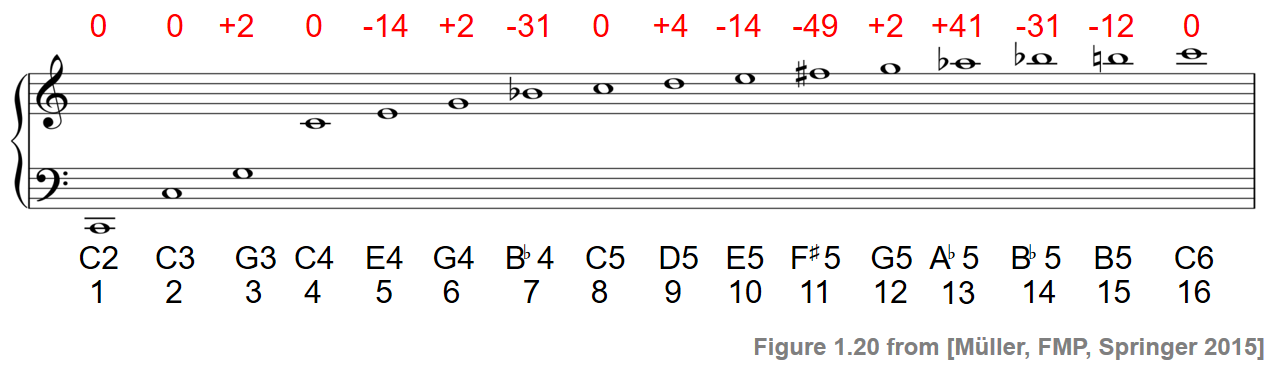

In [17]:
Image("../img/2.music_representation/FMP_C1_F20.png", width=500, height=500)

- 예를 들어, 세 번째 고조파의 주파수는 G3의 중심 주파수보다 겨우 2센트 높은데, 이는 눈에 띄는 차이보다 훨씬 작다. 
- 이와 대조적으로 11차 고조파의 주파수는 음표 F5의 중심 주파수보다 49센트 낮으며, 이는 반음에 가깝고 또렷하게 들린다. 
- 만약 고조파가 (주파수를 2의 거듭제곱으로 적절히 곱하거나 나누어서) 한 옥타브의 범위로 옮겨진다면, 그것들은 12톤의 동일한 성질의 음계의 특정 음에 근접한다. 
- 열두 음계 중 일부는 C(1차 고조파), G(3차 고조파), D(9차 고조파)와 같이 근사치가 좋은 반면, F(11차 고조파), A$^\flat$(13차 고조파) 또는 B$^\flat$(7차 고조파)와 같이 문제가 있는 단계도 있다.

- 아래의 코드는 위 그림에 나온 16 고조파와 16 중심주파수를 모두 사인파로 생성한다.

In [18]:
import libfmp.c1

# Computation of frequencies and differences
p = 36
freq = libfmp.c1.f_pitch(p)
freq_harmonic = (np.asarray(range(16)) + 1) * freq
sinusoid_freq_harmonic = []
notes = np.asarray([36, 48, 55, 60, 64, 67, 70, 72, 74, 76, 78, 79, 80, 82, 83, 84])
freq_center = libfmp.c1.f_pitch(notes)
sinusoid_freq_center = []
freq_deviation_cents =  libfmp.c1.difference_cents(freq_harmonic, freq_center)

# Generation of sinusoids
dur = 1  # seconds
Fs = 4000  # sampling rate

for freq in freq_center:
    x, t = libfmp.c1.generate_sinusoid(dur=dur, Fs=Fs, freq=freq)
    sinusoid_freq_center.append(x)

for freq in freq_harmonic:
    x, t = libfmp.c1.generate_sinusoid(dur=dur, Fs=Fs, freq=freq)
    sinusoid_freq_harmonic.append(x)    

# Generation of html table    
audio_tag_html_center = []
for i in range(len(freq_center)):
    audio_tag = ipd.Audio(sinusoid_freq_center[i], rate=Fs)
    audio_tag_html = audio_tag._repr_html_().replace('\n', '').strip()
    audio_tag_html = audio_tag_html.replace('<audio ', '<audio style="width: 100px; "')  
    audio_tag_html_center.append(audio_tag_html)
    
audio_tag_html_harmonic = []
for i in range(len(freq_harmonic)):
    audio_tag = ipd.Audio(sinusoid_freq_harmonic[i], rate = Fs)
    audio_tag_html = audio_tag._repr_html_().replace('\n', '').strip()
    audio_tag_html = audio_tag_html.replace('<audio ', '<audio style="width: 100px; "')    
    audio_tag_html_harmonic.append(audio_tag_html)

pd.set_option('display.max_colwidth', None)    
df = pd.DataFrame(OrderedDict([('Note', ['C2', 'C3', 'G3', 'C4', 'E4', 'G4',
                                         'B$^\\flat$4', 'C5', 'D5', 'E5', 'F$^\sharp$5',
                                         'G5', 'A$^\\flat$5', 'B$^\\flat$5', 'B5', 'C6']),
                               ('Note Freq. (Hz)', freq_center),
                               ('Note Sinusoid', audio_tag_html_center),                               
                               ('Harmonic Freq. (Hz)', freq_harmonic),
                               ('Harmonic Sinusoid', audio_tag_html_harmonic),                               
                               ('Deviation (Cents)', freq_deviation_cents)]))

df.index = np.arange(1, len(df) + 1)
ipd.HTML(df.to_html(escape=False, float_format='%.2f'))

- 다음 코드 셀에서, 각각 16개의 고조파 주파수와 16개의 중심 주파수에 대해 사인파를 중첩(superimpose)한다. 
- 첫 번째 경우에는 균일한 소리(단일 음으로 인식됨)를 얻는 반면, 두 번째 소리는 더 이질적이다.

In [19]:
num_sinusoid = 16
x_all_harmonic = sinusoid_freq_harmonic[0]
x_all_center = sinusoid_freq_center[0]
for i in range(num_sinusoid-1):
    x_all_harmonic = x_all_harmonic + sinusoid_freq_harmonic[i+1]    
    x_all_center = x_all_center + sinusoid_freq_center[i+1]

x_all_harmonic = x_all_harmonic / num_sinusoid
x_all_center = x_all_center / num_sinusoid

print('Superposition of sinusoids with frequencies from harmonics:')
ipd.display(ipd.Audio(data=x_all_harmonic, rate=Fs))
print('Superposition of sinusoids with frequencies from notes:')
ipd.display(ipd.Audio(data=x_all_center, rate=Fs))

Superposition of sinusoids with frequencies from harmonics:


Superposition of sinusoids with frequencies from notes:


---
### 다이나믹, 인텐시티 및 라우드니스 Dynamics, Intensity, and Loudness

**데시벨 스케일 (Decibel Scale)**

- 음악의 중요한 특성은 음량을 나타내는 음악 기호뿐만 아니라 음량을 나타내는 일반적인 용어인 **dynamics**와 관련이 있다. 
- 물리적 관점에서 **sound power**은 공기를 통해 모든 방향으로 흐르는 음원에 의해 단위 시간당 얼마나 많은 에너지가 방출되는지를 나타낸다. 
- 그런 다음 **sound intensity**라는 용어를 사용하여 단위 면적당 사운드 파워를 나타낸다. 실제로 sound power와 sound intensity는 인간 청취자와 여전히 관련이 있는 극히 작은 값을 보여줄 수 있다. 예를 들어, 인간이 들을 수 있는 순수 음색(pure tone)의 최소 소리 강도인 **청각의 임계값**(threshold of hearing, TOH)은 다음과 같이 작다.

\begin{equation}
I_\mathrm{TOH}:=10^{-12}~\mathrm{W}/\mathrm{m}^2.
\end{equation}

- 게다가, 인간이 지각할 수 있는 강도(intensity)의 범위는 $I_\mathrm{TOP}:=10~\mathrm{W}/\mathrm{m}^2$ (**통증 임계값**(TOP))으로 매우 크다. 
- 실질적인 이유로, 힘과 강도를 표현하기 위해 로그 척도로 전환한다. 더 정확하게는 두 값 사이의 비율을 나타내는 로그 단위인 **데시벨**(dB) 척도를 사용한다. 
- 일반적으로 sound intensity의 경우 $I_\mathrm{TOH}$과 같은 값 중 하나가 참조 역할을 한다.  
- 그런 다음 dB에서 측정된 강도는 다음과 같이 정의된다.

\begin{equation}
   \mathrm{dB}(I) := 10\cdot \log_{10}\left(\frac{I}{I_\mathrm{TOH}}\right).
\end{equation}

- 위의 정의에서 From this definition, one obtains $\mathrm{dB}(I_\mathrm{TOH})=0$를 얻을 수 있고, 강도가 두배로 증가하면 대략 3dB 증가한다:
\begin{equation}
     \mathrm{dB}(2\cdot I) = 10\cdot \log_{10}(2) + \mathrm{dB}(I) \approx 3 + \mathrm{dB}(I).
\end{equation}

- 데시벨 단위로 강도 값을 지정할 때 **강도 수준**(intensity levels)도 언급된다. 
- 다음 표는 $\mathrm{W}/\mathrm{m}^2$ 와 데시벨 단위로 몇 가지 일반적인 강도값(intensity value)을 보여준다.

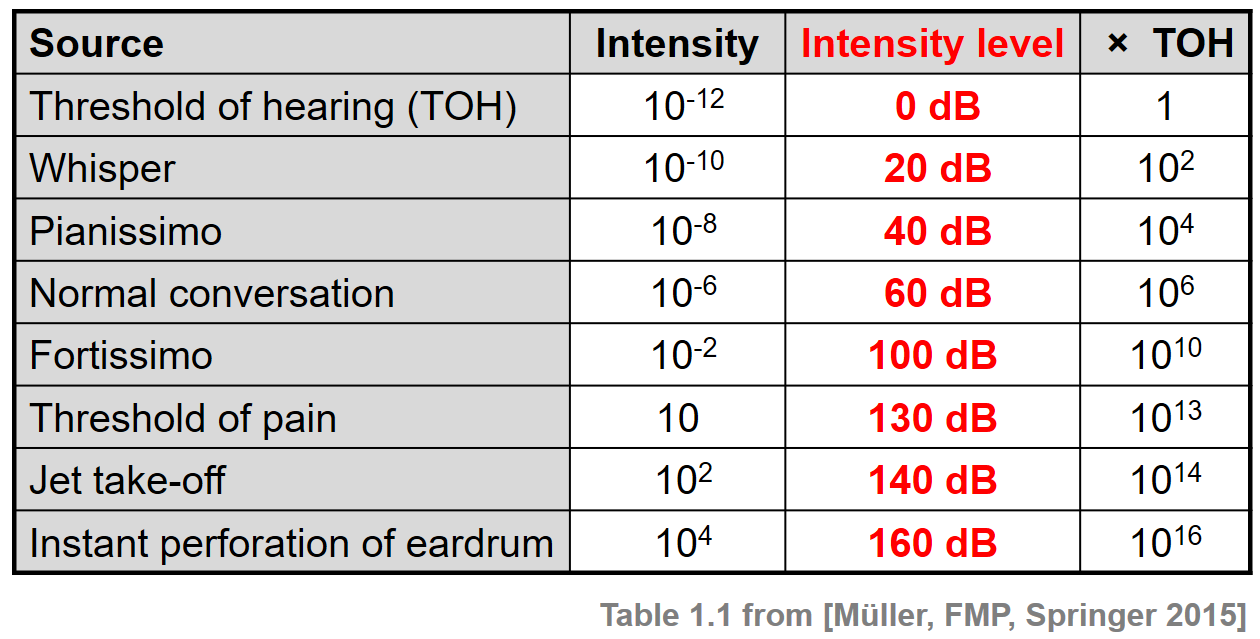

In [20]:
Image("../img/2.music_representation/FMP_C1_T01.png", width=400, height=400)

예시
- Frank Ocean - Comme des Garçons

<audio src="../audio/private/Comme-des-Garcons.wav" type="audio/mpeg" controls="controls"></audio>

In [21]:
def compute_power_db(x, Fs, win_len_sec=0.1, power_ref=10**(-12)):
    """Computation of the signal power in dB

    Args:
        x (np.ndarray): Signal (waveform) to be analyzed
        Fs (scalar): Sampling rate
        win_len_sec (float): Length (seconds) of the window (Default value = 0.1)
        power_ref (float): Reference power level (0 dB) (Default value = 10**(-12))

    Returns:
        power_db (np.ndarray): Signal power in dB
    """
    win_len = round(win_len_sec * Fs)
    win = np.ones(win_len) / win_len
    power_db = 10 * np.log10(np.convolve(x**2, win, mode='same') / power_ref)
    return power_db

In [22]:
Fs = 22050
x, Fs = librosa.load("../audio/private/Comme-des-Garcons.wav", sr=Fs, mono=True)

win_len_sec = 0.2
power_db = compute_power_db(x, win_len_sec=win_len_sec, Fs=Fs)

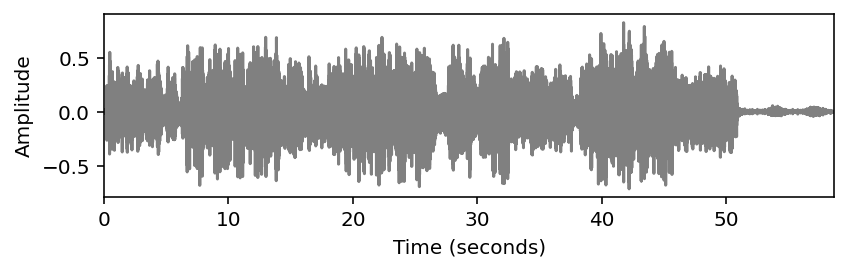

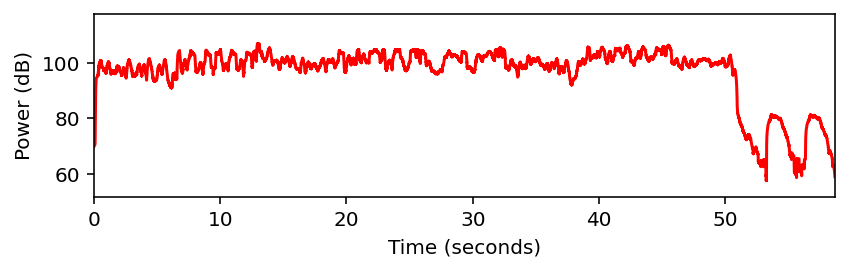

In [25]:
plot_signal(x, Fs, ylabel='Amplitude', color='gray')
plot_signal(power_db, Fs, ylabel='Power (dB)', color='red')
plt.show()

**Loudness**

- Dynamics과 sound intensity는 소리가 조용한 것에서 큰 것으로 확장되는 규모로 소리를 정렬할 수 있는 Loudness고 불리는 지각적 특성과 관련이 있다. 
- Loudness은 주관적인 측정이며, 이는 개별 청취자(예: 나이는 소리에 대한 인간의 귀의 반응에 영향을 미치는 요인 중 하나)뿐만 아니라 지속 시간 또는 주파수와 같은 다른 소리 특성에도 영향을 미친다. 
    - 예를 들어, 사람은 200ms 동안 지속되는 소리가 50ms 동안만 지속되는 유사한 소리보다 더 크게 느껴진다. 
    - 게다가, 강도는 같지만 주파수가 다른 두 소리는 일반적으로 동일한 loudness로 인식되지 않는다. 
    - 정상적인 청력을 가진 사람은 2~4kHz 정도의 소리에 가장 민감하며, 낮은 주파수뿐만 아니라 높은 주파수에서도 감도가 감소한다. 

- 정신음향(psychoacoustic) 실험을 바탕으로 주파수에 따른 pure tone의 지각된 loudness을 단위폰(unit phon)으로 결정되고 표현되어 왔다. 
- 다음 그림은 동일한 음량 윤곽선(equal loudness contours)을 보여준다. 각 윤곽선은 폰(phon)으로 주어진 고정된 음량에 대해 (로그로 간격을 둔) 주파수 축에 대한 소리 강도를 지정한다. 하나의 폰 단위는 1000Hz의 주파수에 대해 정규화되며, 여기서 하나의 폰 값은 dB 단위의 강도 수준과 같다. 0 폰의 윤곽선은 주파수에 따라 청각 임계값(threshold of hearing)이 어떻게 달라지는지를 보여준다.

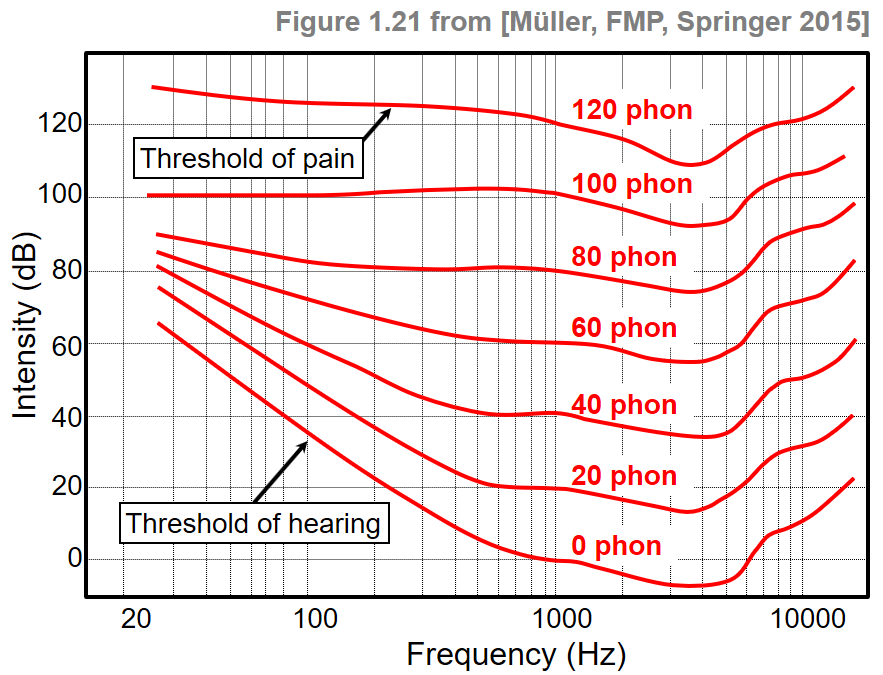

In [26]:
Image("../img/2.music_representation/FMP_C1_F21.png", width=400, height=400)

- 윤곽선은 가중치 함수에 의해 대략적으로 설명될 수 있다. 다음 코드 셀에서 동일한 음량 윤곽선에 질적으로 근사하는 함수의 예를 찾을 수 있다.

In [27]:
def compute_equal_loudness_contour(freq_min=30, freq_max=15000, num_points=100):
    """Computation of the equal loudness contour

    Notebook: C1/C1S3_Dynamics.ipynb

    Args:
        freq_min (float): Lowest frequency to be evaluated (Default value = 30)
        freq_max (float): Highest frequency to be evaluated (Default value = 15000)
        num_points (int): Number of evaluation points (Default value = 100)

    Returns:
        equal_loudness_contour (np.ndarray): Equal loudness contour (in dB)
        freq_range (np.ndarray): Evaluated frequency points
    """
    freq_range = np.logspace(np.log10(freq_min), np.log10(freq_max), num=num_points)
    freq = 1000
    # Function D from https://bar.wikipedia.org/wiki/Datei:Acoustic_weighting_curves.svg
    h_freq = ((1037918.48 - freq**2)**2 + 1080768.16 * freq**2) / ((9837328 - freq**2)**2 + 11723776 * freq**2)
    n_freq = (freq / (6.8966888496476 * 10**(-5))) * np.sqrt(h_freq / ((freq**2 + 79919.29) * (freq**2 + 1345600)))
    h_freq_range = ((1037918.48 - freq_range**2)**2 + 1080768.16 * freq_range**2) / ((9837328 - freq_range**2)**2
                                                                                     + 11723776 * freq_range**2)
    n_freq_range = (freq_range / (6.8966888496476 * 10**(-5))) * np.sqrt(h_freq_range / ((freq_range**2 + 79919.29) *
                                                                         (freq_range**2 + 1345600)))
    equal_loudness_contour = 20 * np.log10(np.abs(n_freq / n_freq_range))
    return equal_loudness_contour, freq_range

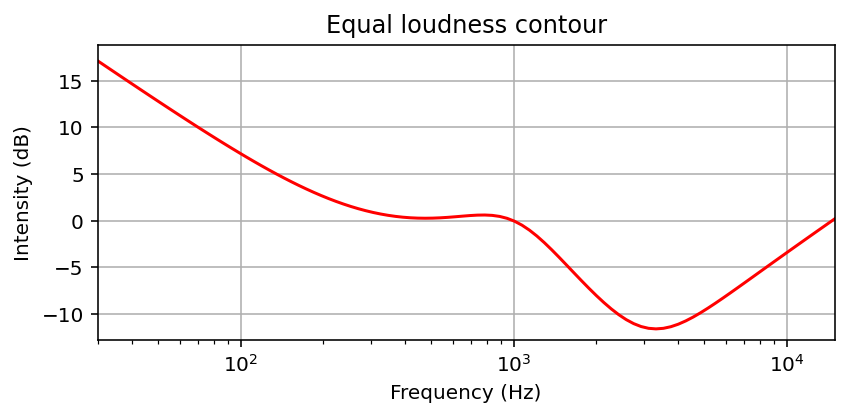

In [30]:
equal_loudness_contour, freq_range = compute_equal_loudness_contour()

plot_signal(equal_loudness_contour, T_coef=freq_range, figsize=(6,3), xlabel='Frequency (Hz)',
            ylabel='Intensity (dB)', title='Equal loudness contour', color='red')
plt.xscale('log')
plt.grid()
plt.show()

**Chirp Signal with Equal Power**

- 이제 30Hz에서 시작하여 10000Hz로 끝나는, 주파수가 기하급수적으로 증가하는 차프 신호에 대한 작은 실험을 수행해보자. 
- 먼저, 전체 시간 간격에 걸쳐 동일한 강도의 차프 신호를 생성한다. 이 신호를 들을 때는 주파수가 증가함에 따라 신호가 먼저 커지고 약 4000Hz의 주파수를 지나면 다시 부드러워지는 느낌이 든다.

In [31]:
def generate_chirp_exp(dur, freq_start, freq_end, Fs=22050):
    """Generation chirp with exponential frequency increase

    Args:
        dur (float): Length (seconds) of the signal
        freq_start (float): Start frequency of the chirp
        freq_end (float): End frequency of the chirp
        Fs (scalar): Sampling rate (Default value = 22050)

    Returns:
        x (np.ndarray): Generated chirp signal
        t (np.ndarray): Time axis (in seconds)
        freq (np.ndarray): Instant frequency (in Hz)
    """
    N = int(dur * Fs)
    t = np.arange(N) / Fs
    freq = np.exp(np.linspace(np.log(freq_start), np.log(freq_end), N))
    phases = np.zeros(N)
    for n in range(1, N):
        phases[n] = phases[n-1] + 2 * np.pi * freq[n-1] / Fs
    x = np.sin(phases)
    return x, t, freq

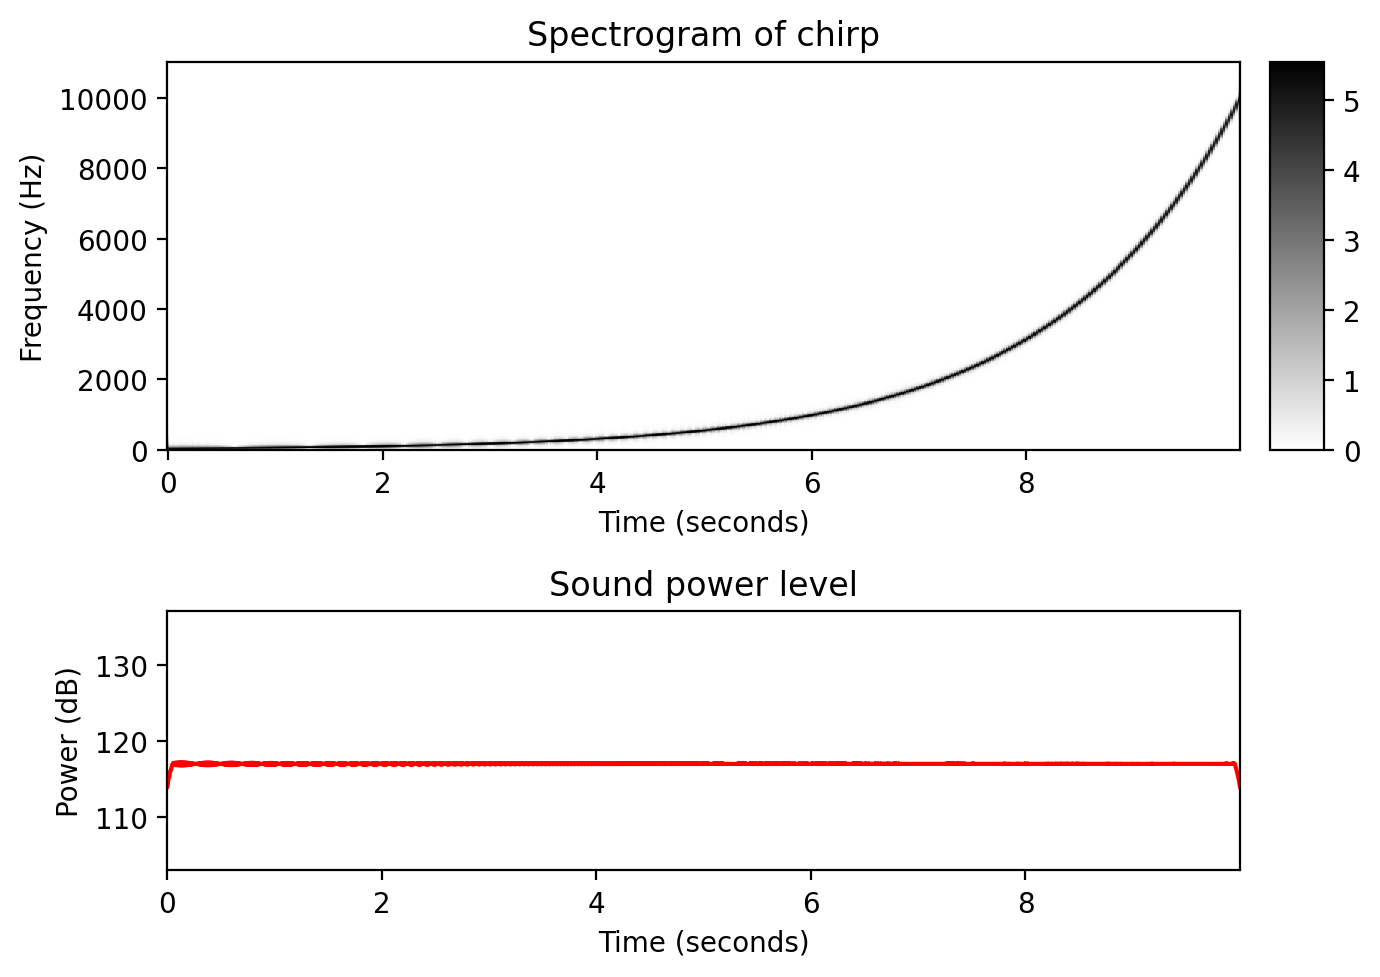

In [32]:
Fs = 22050
freq_start = 30 
freq_end = 10000
dur = 10
x, t, freq = generate_chirp_exp(dur, freq_start, freq_end, Fs=Fs)


fig, ax = plt.subplots(2, 2, gridspec_kw={'width_ratios': [1, 0.05], 
                                          'height_ratios': [3, 2]}, figsize=(7, 5))
N, H = 1024, 512
X = librosa.stft(x, n_fft=N, hop_length=H, win_length=N, pad_mode='constant')
plot_matrix(np.log(1+np.abs(X)), Fs=Fs/H, Fs_F=N/Fs, ax=[ax[0,0], ax[0,1]], 
            title='Spectrogram of chirp', colorbar=True)

win_len_sec = 0.1
power_db = compute_power_db(x, win_len_sec=win_len_sec, Fs=Fs)
plot_signal(power_db, Fs=Fs, ax=ax[1,0], title='Sound power level', ylabel='Power (dB)', color='red')
ax[1,0].set_ylim([103, 137])
ax[1,1].set_axis_off()
plt.tight_layout()
plt.show()

display(Audio(x, rate=Fs) )

**Chirp Signal with Equal Loudness**

- 둘째로, 위에서 생성된 equal loudness 윤곽에 따라 신호의 진폭(amplitude)을 조정한다. 
- 이 경우 전체 주파수 범위를 통해 스위핑할 때 결과로 발생하는 chirp 신호의 loudness이 동일한 것으로 보인다.

In [33]:
def generate_chirp_exp_equal_loudness(dur, freq_start, freq_end, Fs=22050):
    """Generation chirp with exponential frequency increase and equal loudness

    Args:
        dur (float): Length (seconds) of the signal
        freq_start (float): Starting frequency of the chirp
        freq_end (float): End frequency of the chirp
        Fs (scalar): Sampling rate (Default value = 22050)

    Returns:
        x (np.ndarray): Generated chirp signal
        t (np.ndarray): Time axis (in seconds)
        freq (np.ndarray): Instant frequency (in Hz)
        intensity (np.ndarray): Instant intensity of the signal
    """
    N = int(dur * Fs)
    t = np.arange(N) / Fs
    intensity, freq = compute_equal_loudness_contour(freq_min=freq_start, freq_max=freq_end, num_points=N)
    amp = 10**(intensity / 20)
    phases = np.zeros(N)
    for n in range(1, N):
        phases[n] = phases[n-1] + 2 * np.pi * freq[n-1] / Fs
    x = amp * np.sin(phases)
    return x, t, freq, intensity

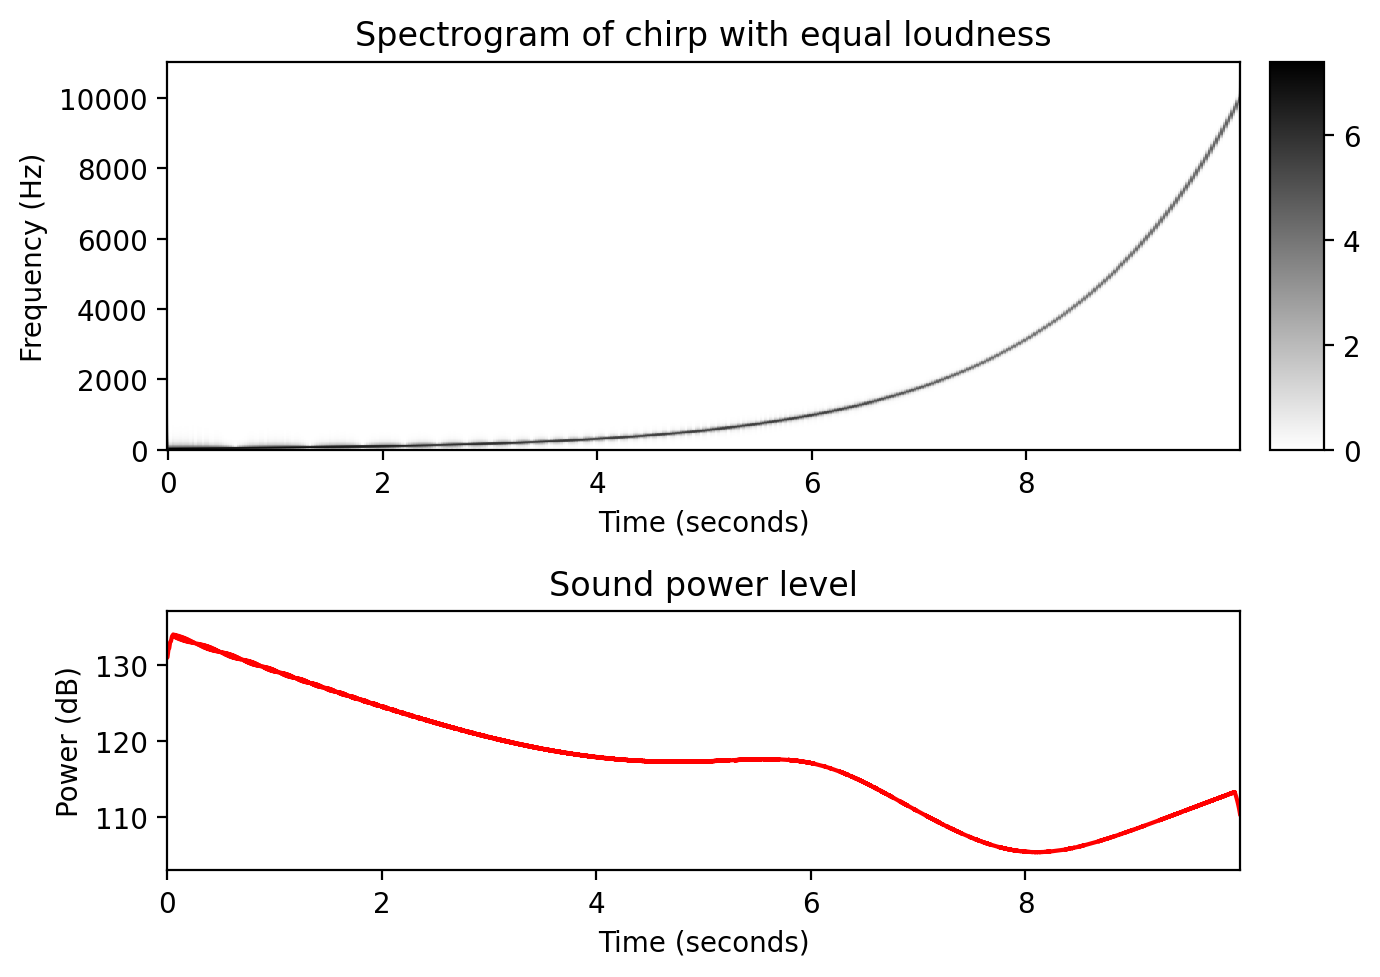

In [34]:
x_equal_loudness, t, freq, intensity = generate_chirp_exp_equal_loudness(dur, freq_start, freq_end, Fs=Fs)

fig, ax = plt.subplots(2, 2, gridspec_kw={'width_ratios': [1, 0.05], 
                                          'height_ratios': [3, 2]}, figsize=(7, 5))
N, H = 1024, 512
X = librosa.stft(x_equal_loudness, n_fft=N, hop_length=H, win_length=N, pad_mode='constant')
plot_matrix(np.log(1+np.abs(X)), Fs=Fs/H, Fs_F=N/Fs, ax=[ax[0,0], ax[0,1]], 
                     title='Spectrogram of chirp with equal loudness', colorbar=True)

win_len_sec = 0.1
power_db = compute_power_db(x_equal_loudness, win_len_sec=win_len_sec, Fs=Fs)
plot_signal(power_db, Fs=Fs, ax=ax[1,0], title='Sound power level', ylabel='Power (dB)', color='red')
ax[1,0].set_ylim([103, 137])
ax[1,1].set_axis_off()
plt.tight_layout()
plt.show()

display( Audio(x_equal_loudness, rate=Fs) )